## Load data

In [14]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt

# load calcium data
y_ref = np.loadtxt("canorm_tracjectories.csv", delimiter=",")

# load parameters
all_pop_mat = scipy.io.loadmat("../../data/TrajRepeatFit1004to604Pop100LastPop/TrajNum1004_1/AllPops_1004_1.mat")
all_pop_params = all_pop_mat["AllPops"].squeeze()
last_good_pop_mat = scipy.io.loadmat("../../data/TrajRepeatFit1004to604Pop100LastPop/TrajNum1004_1/lastPopGoodModels.mat")
last_good_pop_params = last_good_pop_mat["lastPopGoodModels"]

# map between parameter indices in Wollman's SBML file and those in calcium_ode()
param_map = [0, 20, 1, 2, 3, 4, 5, 6, 7, 11, 10, 8, 9, 17, 13, 14, 15, 16, 12]

In [1]:
# 0: KonATP
# 1: Katp
# 2: KoffPLC
# 3: Vplc
# 4: Kip3
# 5: KoffIP3
# 6: a
# 7: dinh
# 8: d1
# 9: d5
# 10: Be
# 11: Ke
# 12: k3
# 13: eta1
# 14: eta2
# 15: eta3
# 16: c0
# 17: epr
# 18: beta
# 19: minf
# 20: L
def calcium_ode(t, y, theta):
    dydt = np.zeros(4)

    dydt[0] = theta[0]* theta[20] * np.exp(-theta[1] * t) - theta[2] * y[0]
    dydt[1] = (theta[3] * y[0] * y[0]) \
        / (theta[4] * theta[4] + y[0] * y[0]) - theta[5] * y[1]
    dydt[2] = theta[6] * (y[3] + theta[7]) \
        * (theta[7] / (y[3] * theta[7]) - y[2])
    dydt[3] = 1 / theta[18] * (
        theta[17]
            * (theta[13] * np.power(theta[19], 3) * np.power(y[2], 3) + theta[14])
            * (theta[16] - (1 + theta[17]) * y[3])
        - theta[15] * np.power(y[3], 2)
            / (np.power(theta[12], 2) + np.power(y[3], 2))
    )

    return dydt

## Initial population

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c2e064588>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c2e064208>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c2fb0b2b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c2fb0b978>}

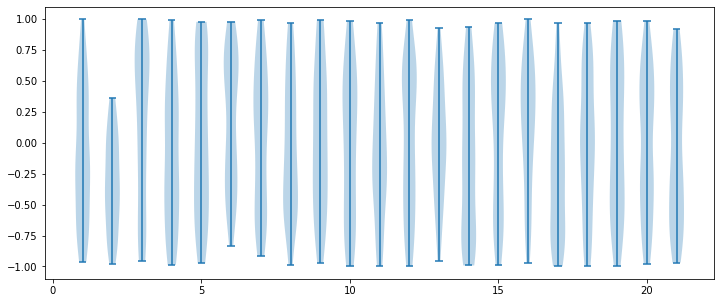

In [22]:
plt.figure(figsize=(12, 5))
plt.violinplot(all_pop_params[0])

## Last population

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c2f8b5160>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c2f8b5cc0>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c300472b0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c30047978>}

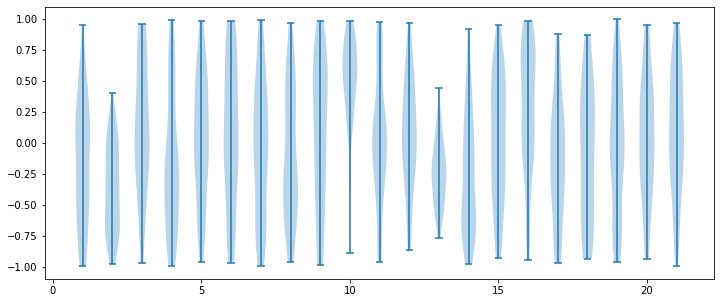

In [25]:
plt.figure(figsize=(12, 5))
plt.violinplot(all_pop_params[-1])

## Last "good" population

{'bodies': [<matplotlib.collections.PolyCollection at 0x1c300e77f0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1c300e77b8>,
 'cmins': <matplotlib.collections.LineCollection at 0x1c2e787208>,
 'cbars': <matplotlib.collections.LineCollection at 0x1c2e7878d0>}

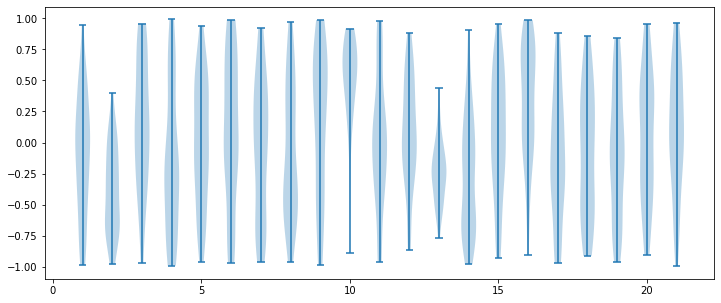

In [24]:
plt.figure(figsize=(12, 5))
plt.violinplot(last_good_pop_params)

In [2]:
def simulate_trajectory(theta, y_init, t):
    """simulate a trajectory with sampled parameters"""
    # initialize ODE solver
    solver = scipy.integrate.ode(calcium_ode)
    solver.set_integrator("dopri5")
    solver.set_f_params(theta)
    solver.set_initial_value(y_init, t[0])

    # perform numerical integration
    y = np.zeros_like(t)
    y[0] = y_init[3]
    it = 1
    while solver.successful() and i < t.size:
        solver.integrate(t[it])
        y[it] = solver.y[3]

        it += 1

    return y

/Users/xiaojunwu/anaconda3/envs/pystan/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/Users/xiaojunwu/anaconda3/envs/pystan/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


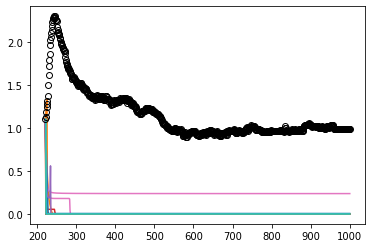

In [3]:
t0, t_end = 221, 1000
ts = np.linspace(t0, t_end, t_end - t0 + 1)
y0 = [0, 0, 0.7, y_ref[0, t0]]

# thetas = all_pop_params[-1][:, param_map]
thetas = last_good_pop_params[:, param_map]
num_samples = thetas.shape[0]
y_sim = np.empty((num_samples, ts.size))
for i, theta_i in enumerate(thetas):
    y_sim[i, :] = simulate_trajectory(theta_i, y0, ts)
y_sim = y_sim[np.all(y_sim < np.amax(y_ref[0, t0:]) * 2, axis=1), :]
plt.plot(ts, y_sim.T)
plt.plot(ts, y_ref[0, t0:], "ko", fillstyle="none")
